In [4]:
import glob
import numpy as np
from PIL import Image
import torch 
import torch.nn as nn
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
from skimage.color import rgb2lab, lab2rgb
from torchvision import transforms

In [5]:
%env CUDA_VISIBLE_DEVICES=""

env: CUDA_VISIBLE_DEVICES=""


In [6]:
set_dir = glob.glob('./../dataset/*.jpg')
train_set = set_dir[:5703]
val_set = set_dir[5703:]

In [7]:
PIC_SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths):
        self.transforms = transforms.Resize((PIC_SIZE, PIC_SIZE),  Image.BICUBIC)
        
        self.pic_size = PIC_SIZE
        self.paths = paths
        
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype('float32')
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. -1.
        ab = img_lab[[1, 2], ...] / 110.
                
        return {'L': L, 'ab':ab}
    
    def __len__(self):
        return len(self.paths)

In [8]:
def make_dataloaders(batch_size=16, n_workers=2, pin_memory=True, **kwargs):
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,pin_memory=pin_memory)
    
    return dataloader

train_dl = make_dataloaders(paths=train_set)

In [9]:
class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
    def forward(self, inputs):
        x = relu(self.conv1(inputs))
        x = relu(self.conv2(x))
        
        return x

In [10]:
class Encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convolution = Conv_block(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
    def forward (self, inputs):
        x = self.convolution(inputs)
        p = self.pool(x)
        
        return x, p

In [11]:
class Decoder_block(nn.Module):
    def __init__ (self, in_channels, out_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)
        self.dconv1 = nn.Conv2d(in_channels+out_channels, out_channels, kernel_size=3, padding=1)
        self.dconv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
    def forward(self, inputs, skip):
        x = self.upconv(inputs)
        x = torch.cat([x, skip], dim=1)
        x = relu(self.dconv1(x))
        x = relu(self.dconv2(x))
        
        return x

In [12]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        #Encoder part
        self.econv1 = Encoder_block(1, 64)
        self.econv2 = Encoder_block(64, 128)
        self.econv3 = Encoder_block(128, 256)
        self.econv4 = Encoder_block(256, 512)
        
        #Bootleneck
        self.b = Conv_block(512, 1024)
        
        #Decoder part
        self.dconv1 = Decoder_block(1024, 512)
        self.dconv2 = Decoder_block(512,256)
        self.dconv3 = Decoder_block(256, 128)
        self.dconv4 = Decoder_block(128, 64)
        
        #Output layer
        self.outconv = nn.Conv2d(64, 2, kernel_size = 1)
        
    def forward (self, inputs):
        #Encoder part
        x1, p1 = self.econv1(inputs)
        x2, p2 = self.econv2(p1)       
        x3, p3 = self.econv3(p2)        
        x4, p4 = self.econv4(p3)
        
        #Bootleneck
        b = self.b(p4)
        
        #Decoder part
        d1 = self.dconv1(b, x4)
        d2 = self.dconv2(d1, x3)
        d3 = self.dconv3(d2, x2)
        d4 = self.dconv4(d3, x1)
        
        #Output layer
        out = self.outconv(d4)
        
        return out
    
    def predict(self, input_data):
        self.eval()
        
        with torch.no_grad():
            pred = self.forward(input_data)
            
        prediction = torch.cat ((input_data, pred), dim=1)
        prediction[:, 0, :, :] += 1.
        prediction[:, 0, :, :] *= 50.
        prediction[:, 1, :, :] *= 110.
        prediction[:, 2, :, :] *= 110.
        pred_arr = prediction.numpy()
        
        from skimage import color
        rgb_image = np.transpose(pred_arr, (0, 2, 3, 1))
        rgb_image = color.lab2rgb(rgb_image[0])
        rgb_image = np.clip(rgb_image, 0, 1) * 255
        rgb_image = rgb_image.astype(np.uint8)
        image_pil = Image.fromarray(rgb_image)
            
        self.train()
        return image_pil

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_dl, epochs, learning_rate=0.001):
    criterion = nn.MSELoss()  # Funkcja straty Mean Squared Error
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for batch_idx, data in tqdm(enumerate(train_dl), total=len(train_dl)):
            inputs, targets = data['L'], data['ab']
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_dl)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

model = UNet().to('cpu')
train_model(model, train_dl, epochs=100, learning_rate=0.0002)

  0%|                                         | 1/357 [01:19<7:54:03, 79.90s/it]


KeyboardInterrupt: 

In [10]:
model = torch.load('./trained_model.pth', map_location='cpu')

In [11]:
from torchsummary import summary
summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
            Conv2d-2         [-1, 64, 256, 256]          36,928
        Conv_block-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
     Encoder_block-5  [[-1, 64, 256, 256], [-1, 64, 128, 128]]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
            Conv2d-7        [-1, 128, 128, 128]         147,584
        Conv_block-8        [-1, 128, 128, 128]               0
         MaxPool2d-9          [-1, 128, 64, 64]               0
    Encoder_block-10  [[-1, 128, 128, 128], [-1, 128, 64, 64]]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
           Conv2d-12          [-1, 256, 64, 64]         590,080
       Conv_block-13          [-1, 256, 64, 64]               0
        M

In [26]:
def ssim_check(validiation_set):
    from skimage.metrics import structural_similarity as ssim
    from tqdm.notebook import tqdm
    ssim_list = list()
    for elements in tqdm(val_set):
        pic = glob.glob(elements)
        img_test = make_dataloaders(paths=pic, batch_size=1)
        channel = next(iter(img_test))

        Ls, abs_ = channel['L'], channel['ab']
        
        pred = model.predict(Ls)
    
        image_ref = Image.open(elements)
        image_ref = image_ref.resize((256, 256), Image.BICUBIC)
        image_ref = np.array(image_ref)
        
        image_pred = np.array(pred)
        
        ssim_val = ssim(image_ref, image_pred, win_size=3, multichannel=True)
        ssim_list.append(ssim_val)       
        
    return ssim_list

In [27]:
ssim_list = ssim_check(val_set)

  0%|          | 0/1426 [00:00<?, ?it/s]

In [28]:
import pickle

In [29]:
with open('ssim_list.pkl', 'wb') as f:
    pickle.dump(ssim_list, f)

In [30]:
with open('ssim_list.pkl', 'rb') as f:
    ssim_list = pickle.load(f)

In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

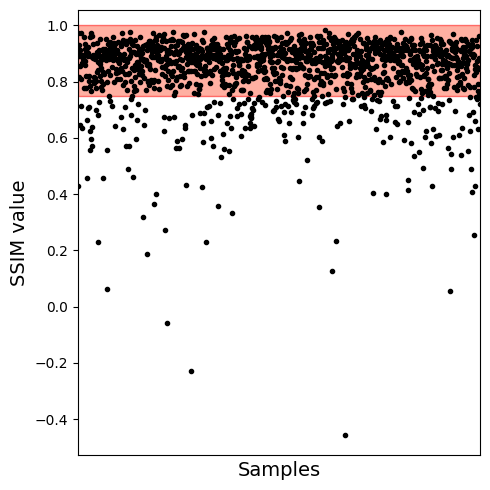

In [36]:
plt.figure(figsize=[5, 5])
plt.plot(np.arange(1, 1427, 1), ssim_list, '.', color='black')
plt.xlabel('Samples', fontsize = 14)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.ylabel('SSIM value', fontsize = 14)
plt.xlim(0, 1426)

rectangle = patches.Rectangle((0, 0.75), 1426, 0.25, linewidth=1, edgecolor='red', facecolor='tomato', alpha=0.5)
plt.gca().add_patch(rectangle)
plt.tight_layout()
plt.savefig('ssim_check.tif', dpi=300)

In [33]:
# Sprawdzić jak duży odsetek próbek znajduje się w zakresie 0,75-1

In [34]:
import os

file_path = 'ssim_list.pkl'

if os.path.getsize(file_path) == 0:
    print("Plik jest pusty.")
else:
    print("Plik nie jest pusty.")

Plik nie jest pusty.
